# **What is METACALIBRATION?**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim

## How do digital images of galaxies form?

In [97]:
#set galaxy properties:
half_light_radius = .8
g = [0.1, 0.3]

#set image properties:
stamp_size = 51
pixel_scale = 0.2

noise_image = 1e-3
noise_psf = noise_image/10

#draw galaxy surface brightness
galaxy=galsim.Exponential(half_light_radius=half_light_radius).shear(g1=g[0],g2=g[1])
galaxy_image = galaxy.drawImage(nx=510,ny=510,scale=pixel_scale/10).array

#draw psf distribution
psf = galsim.Moffat(beta=4.8,fwhm=0.7).shear(g1=0.01,g2=0.02)
psf_image = psf.drawImage(nx=stamp_size*10,ny=stamp_size*10,scale=pixel_scale/10).array

#convolve
obj = galsim.Convolve([galaxy,psf])
object_image = obj.drawImage(nx=stamp_size*10,ny=stamp_size*10,scale=pixel_scale/10).array

#pixelize
pixel_image = obj.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array
#add noise
final_image = pixel_image + noise_image*random.normal(size=[stamp_size,stamp_size])


#psf model from stars
psf_model = psf.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array + noise_psf*random.normal(size=[stamp_size,stamp_size])

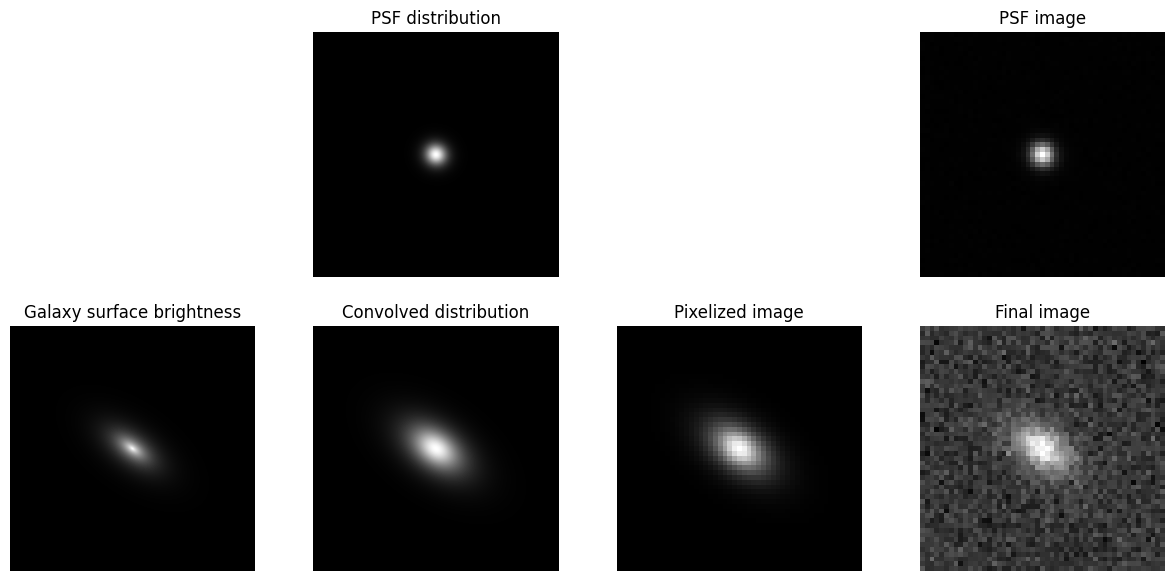

In [98]:
figure(figsize=(15,7))
subplot(245)
imshow(galaxy_image,cmap='gray');axis('off');title('Galaxy surface brightness')
subplot(242)
imshow(psf_image,cmap='gray');axis('off');title('PSF distribution')
subplot(246)
imshow(object_image,cmap='gray');axis('off');title('Convolved distribution')
subplot(247)
imshow(pixel_image,cmap='gray');axis('off');title('Pixelized image')
subplot(248)
imshow(final_image,cmap='gray');axis('off');title('Final image')
subplot(244)
imshow(psf_model,cmap='gray');axis('off');title('PSF image')
savefig('image_formation_paradigm.pdf',bbox_inches='tight')

# How do we measure ellipticities?

## 1) (Weighted) moments over the image

In [102]:
nx = stamp_size
ny = stamp_size
XX = np.zeros([nx,ny])
XY = np.zeros([nx,ny])
YY = np.zeros([nx,ny])
w  = np.zeros([nx,ny])
sigma=1.7/.2 #fwhm/pixel_scale

for i in range(0,nx):
    x=0.5+i-(nx)/2.0
    for j in range(0,ny):
        y=0.5+j-(ny)/2.0
        XX[i,j]=x*x
        XY[i,j]=x*y
        YY[i,j]=y*y
        w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                               (2 * sigma ** 2))

def get_ellipticity(img):
    norm = sum(w*img)
    Q11 = sum(w*img*YY)/norm
    Q12 = sum(w*img*XY)/norm
    Q21 = Q12
    Q22 = sum(w*img*XX)/norm
    
    q1 = Q11 - Q22
    q2 = 2*Q12
    
    T= Q11 + Q22  + 2*np.sqrt(Q11*Q22 - Q12**2)
    return array([q1/T, q2/T])

In [103]:
get_ellipticity(final_image)

array([0.07806257, 0.24233212])

## 2) Model fitting

In [110]:
def model(hlr,g1,g2,psf_fwhm,psf_g1,psf_g2):
  
  gal = galsim.Exponential(
    half_light_radius = hlr
  ).shear(
    g1=g1,
    g2=g2
  )
  
  psf = galsim.Moffat(beta=4.8,
    fwhm = psf_fwhm
  ).shear(
    g1=psf_g1,
    g2=psf_g2
  )
  
  model = galsim.Convolve([gal,psf])
  
  model_array = model.drawImage(
    nx=stamp_size,
    ny=stamp_size,
    scale=pixel_scale
  ).array
  
  return model_array

In [125]:
def loss(g):
  quadratic = sum((model(hlr=0.8,g1=g[0],g2=g[1],psf_fwhm=0.7,psf_g1=0.01,psf_g2=0.02)-final_image)**2)
  return quadratic
  

In [126]:
from scipy.optimize import minimize

In [131]:
result=minimize(loss,array([0,0]),method='Nelder-Mead')
result

 final_simplex: (array([[0.1078387 , 0.30910436],
       [0.10778513, 0.30912526],
       [0.10786546, 0.30913038]]), array([0.00252209, 0.00252209, 0.00252209]))
           fun: 0.0025220850394715505
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 51
        status: 0
       success: True
             x: array([0.1078387 , 0.30910436])

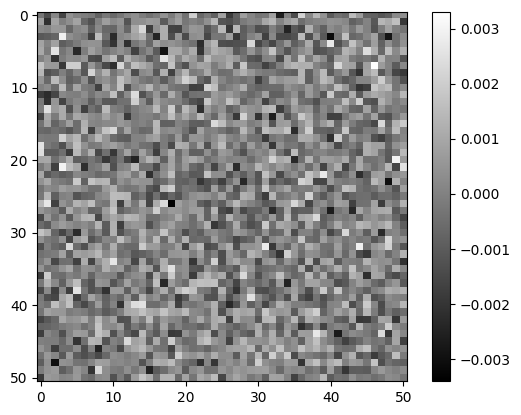

In [133]:
imshow(model(hlr=0.8,g1=result.x[0],g2=result.x[1],psf_fwhm=0.7,psf_g1=0.01,psf_g2=0.02)-final_image,cmap='gray');colorbar()

## METACALIBRATION

To come... :) 